# Recurrent Neural Networks - Emojify using LSTM in Keras Part -2
A more sophisticated model (Emojifier-V2) that further incorporates an LSTM. 


Have you ever wanted to make your text messages more expressive? Your emojifier app will help you do that. So rather than writing "Congratulations on the promotion! Lets get coffee and talk. Love you!" the emojifier can automatically turn this into "Congratulations on the promotion! 👍 Lets get coffee and talk. ☕️ Love you! ❤️"

You will implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️). In many emoji interfaces, you need to remember that ❤️ is the "heart" symbol rather than the "love" symbol. But using word vectors, you'll see that even if your training set explicitly relates only a few words to a particular emoji, your algorithm will be able to generalize and associate words in the test set to the same emoji even if those words don't even appear in the training set. This allows you to build an accurate classifier mapping from sentences to emojis, even using a small training set. 





You have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings)
- Y contains a integer label between 0 and 4 corresponding to an emoji for each sentence

 EMOJISET - a classification problem with 5 classes. A few examples of sentences are given here.

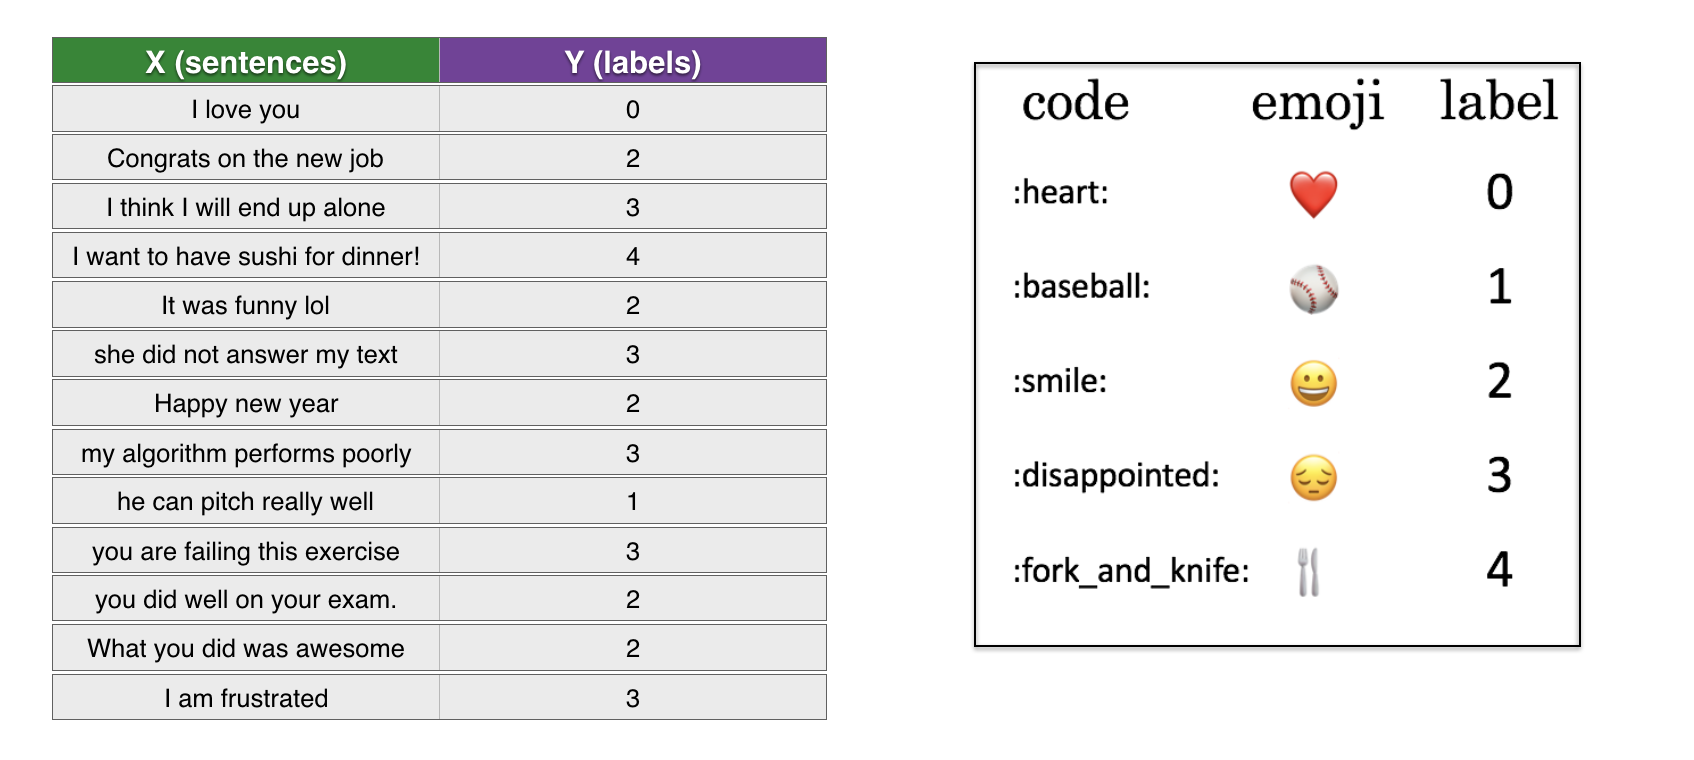

# Emojifier Using LSTMs in Keras

Let's build an LSTM model that takes as input word sequences. This model will be able to take word ordering into account. Emojifier-V2 will continue to use pre-trained word embeddings to represent words, but will feed them into an LSTM, whose job it is to predict the most appropriate emoji. 


In [1]:
import numpy as np
import emoji
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
##################################################
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


##  Dataset EMOJISET

Let's start by building a simple baseline classifier. 

You have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings)
- Y contains a integer label between 0 and 4 corresponding to an emoji for each sentence

 EMOJISET - a classification problem with 5 classes. A few examples of sentences are given here.

In [2]:
def read_csv(filename = '../input/EmojiDS/data/emojify_data.csv'):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

In [3]:
X_train, Y_train = read_csv('../input/EmojiDS/data/train_emoji.csv')
X_test, Y_test = read_csv('../input/EmojiDS/data/tesss.csv')

### Implementing Emojifier

First step is to convert an input sentence into the word vector representation, which then get averaged together. Similar to the previous exercise, we will use pretrained 50-dimensional GloVe embeddings. Run the following cell to load the `word_to_vec_map`, which contains all the vector representations.

In [4]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [5]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../input/EmojiDS/data/glove.6B.50d.txt')

# Model

Emojifier-V2. A 2-layer LSTM sequence classifier

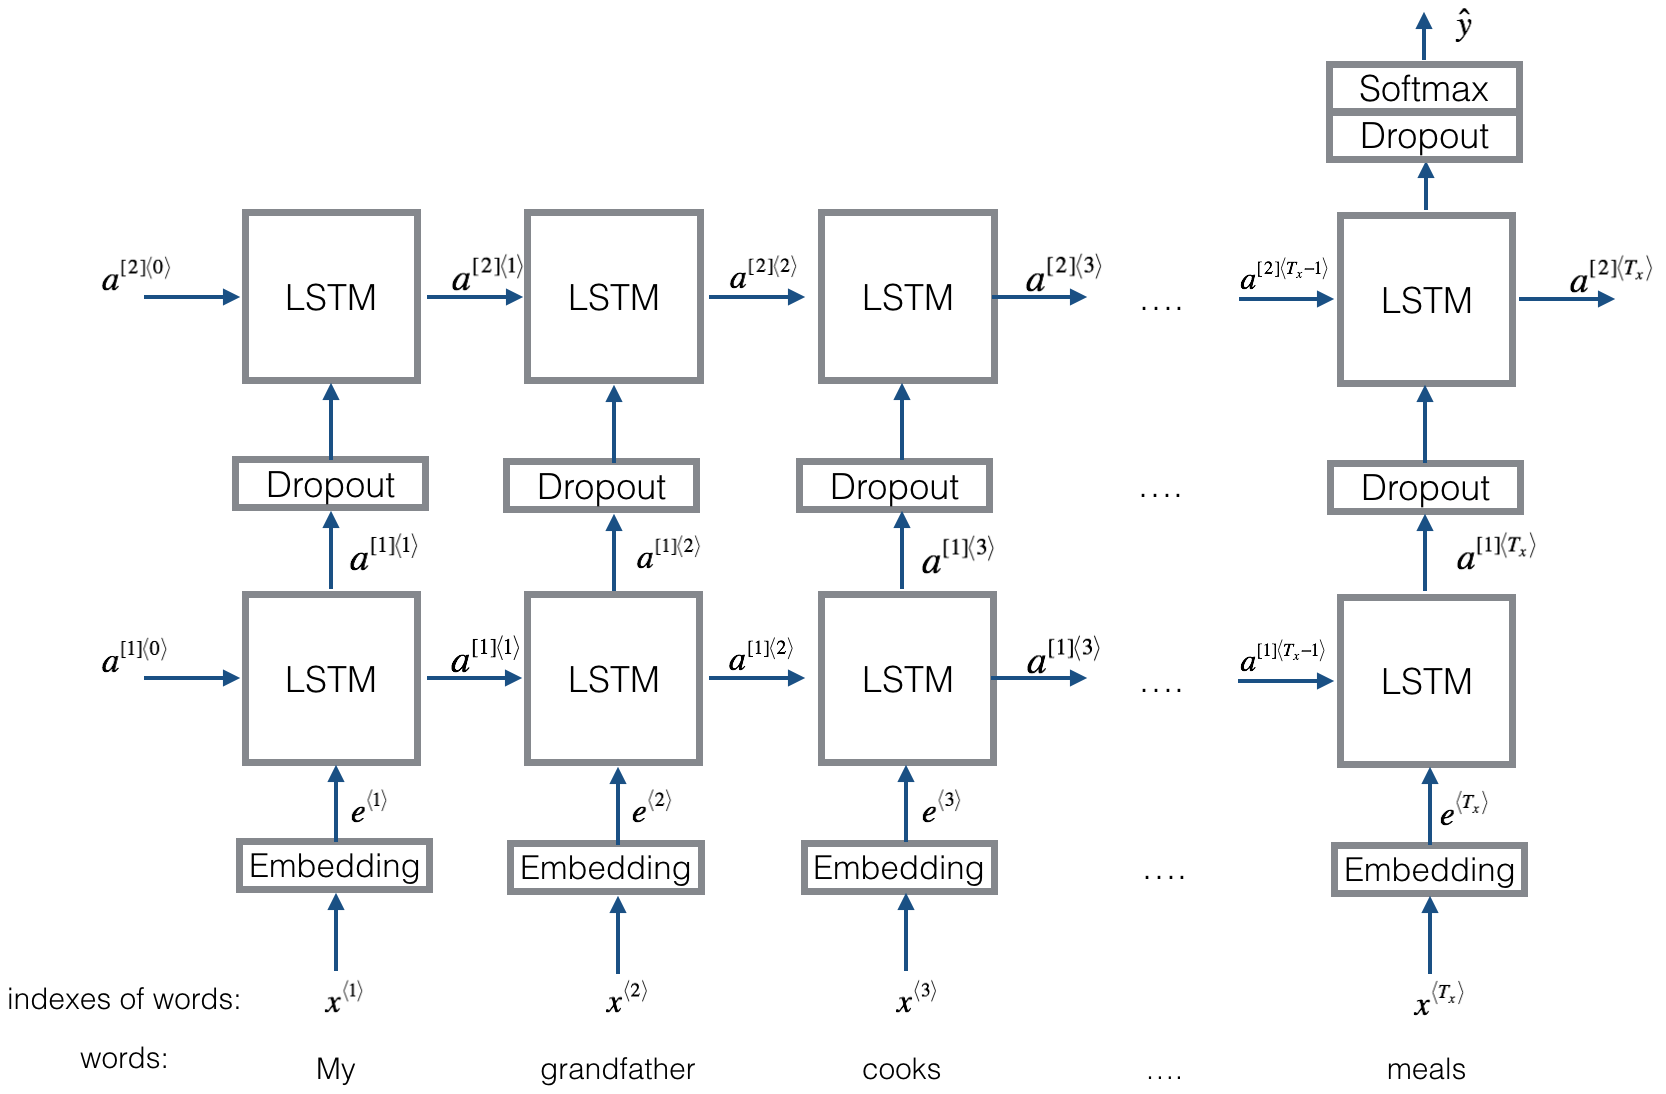 

# Keras and mini-batching 

In this exercise, we want to train Keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the same length. This is what allows vectorization to work: If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.

The common solution to this is to use padding. Specifically, set a maximum sequence length, and pad all sequences to the same length. For example, of the maximum sequence length is 20, we could pad every sentence with "0"s so that each input sentence is of length 20. Thus, a sentence "i love you" would be represented as $(e_{i}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$. In this example, any sentences longer than 20 words would have to be truncated. One simple way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set. 


# The Embedding layer

In Keras, the embedding matrix is represented as a "layer", and maps positive integers (indices corresponding to words) into dense vectors of fixed size (the embedding vectors). It can be trained or initialized with a pretrained embedding. In this part, you will learn how to create an [Embedding()](https://keras.io/layers/embeddings/) layer in Keras, initialize it with the GloVe 50-dimensional vectors loaded earlier in the notebook. Because our training set is quite small, we will not update the word embeddings but will instead leave their values fixed. But in the code below, we'll show you how Keras allows you to either train or leave fixed this layer.  

The `Embedding()` layer takes an integer matrix of size (batch size, max input length) as input. This corresponds to sentences converted into lists of indices (integers), as shown in the figure below.
Embedding layer. This example shows the propagation of two examples through the embedding layer. Both have been zero-padded to a length of `max_len=5`. The final dimension of the representation is  `(2,max_len,50)` because the word embeddings we are using are 50 dimensional.

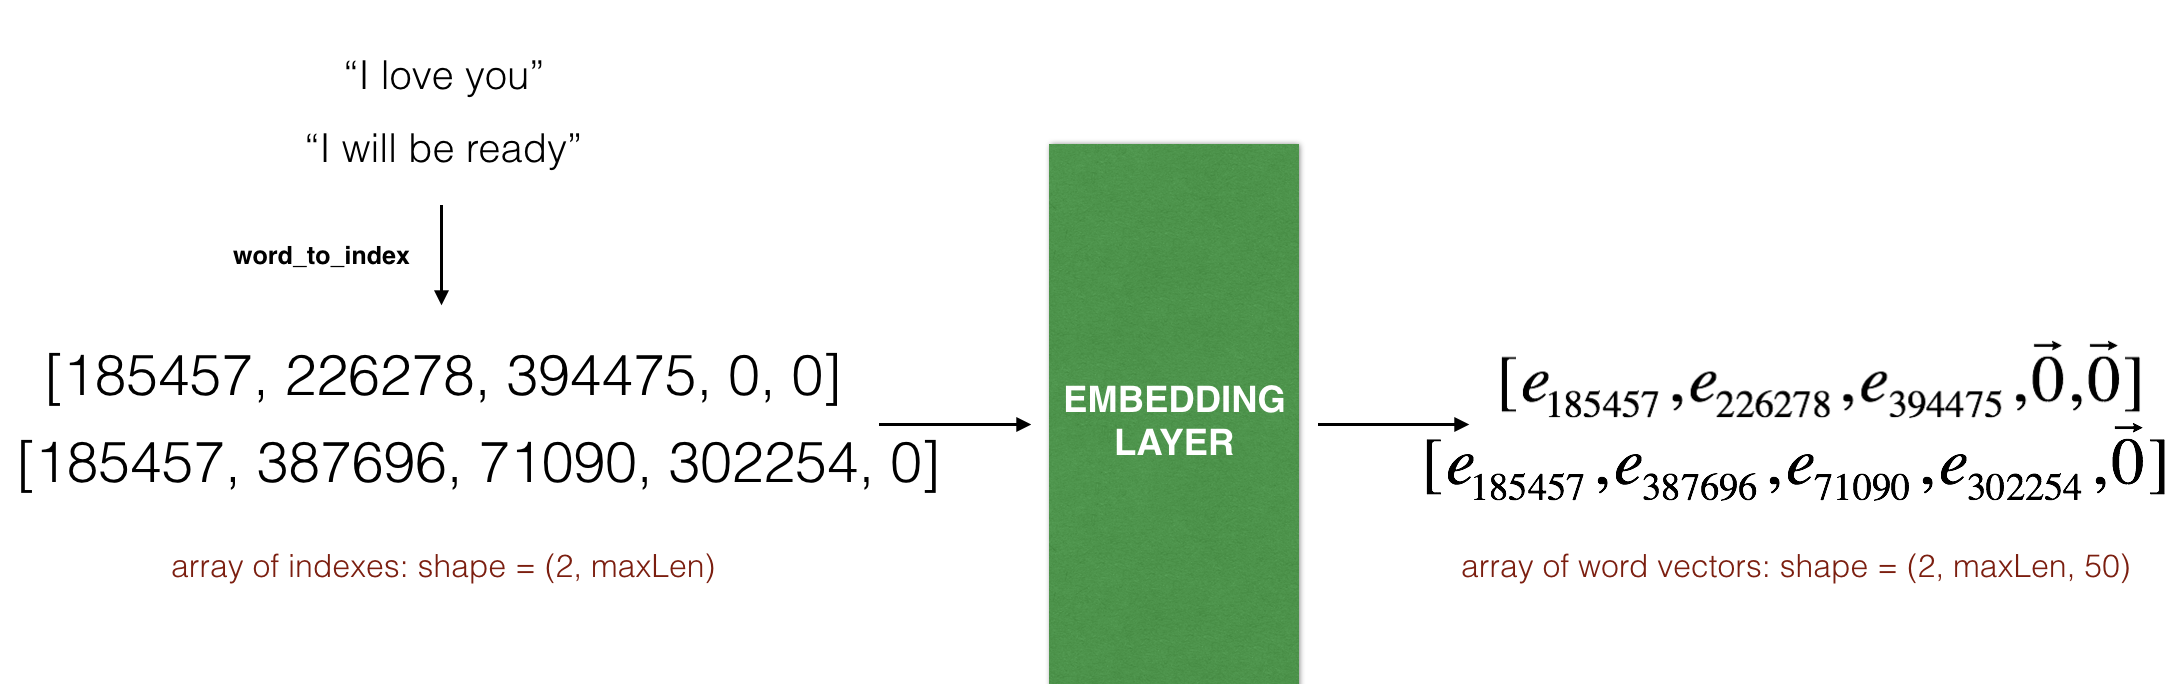

The largest integer (i.e. word index) in the input should be no larger than the vocabulary size. The layer outputs an array of shape (batch size, max input length, dimension of word vectors).

The first step is to convert all your training sentences into lists of indices, and then zero-pad all these lists so that their length is the length of the longest sentence. 

**Implementing sentences_to_indices()**

The function to convert X (array of sentences as strings) into an array of indices corresponding to words in the sentences. The output shape should be such that it can be given to `Embedding()`.




    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)


In [7]:
def sentences_to_indices(X, word_to_index, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j + 1
            
    
    return X_indices

Run the following cell to check what `sentences_to_indices()` does, and check your results.

In [8]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices = [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


Let's build the `Embedding()` layer in Keras, using pre-trained word vectors. After this layer is built, you will pass the output of `sentences_to_indices()` to it as an input, and the `Embedding()` layer will return the word embeddings for a sentence. 

**Implementing `pretrained_embedding_layer()` Steps:**

1. Initialize the embedding matrix as a numpy array of zeroes with the correct shape.
2. Fill in the embedding matrix with all the word embeddings extracted from `word_to_vec_map`.
3. Define Keras embedding layer. Use [Embedding()](https://keras.io/layers/embeddings/). Be sure to make this layer non-trainable, by setting `trainable = False` when calling `Embedding()`. If you were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings. 
4. Set the embedding weights to be equal to the embedding matrix 



         
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance

In [25]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):

    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    
    print(emb_matrix.shape)
    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim) # input_length=10

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [26]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

(400001, 50)
weights[0][1][3] = -0.3403


# Building the Emojifier-V2

Lets now build the Emojifier-V2 model. You will do so using the embedding layer you have built, and feed its output to an LSTM network. 



**Implementing `Emojify_V2()`:** 

builds a Keras graph of the architecture shown in Figure 3. The model takes as input an array of sentences of shape (`m`, `max_len`, ) defined by `input_shape`. It should output a softmax probability vector of shape (`m`, `C = 5`). 


    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras


In [34]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):

    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype=np.int32)
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer =  pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(5, activation='softmax')(X)
    # Add a softmax activation
    #X =  Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)
    
  
    return model

Run the following cell to create your model and check its summary. Because all sentences in the dataset are less than 10 words, we chose `max_len = 10`.  You should see your architecture, it uses "20,223,927" parameters, of which 20,000,050 (the word embeddings) are non-trainable, and the remaining 223,877 are. Because our vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters. 

##  Dataset EMOJISET
You have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings)
- Y contains a integer label between 0 and 4 corresponding to an emoji for each sentence

 EMOJISET - a classification problem with 5 classes. A few examples of sentences are given here.

##### Max words in any line in dataset

In [35]:
print(max(X_train, key=len))
largestLine=max(X_train, key=len)
largestLineWordList=largestLine.split()
maxLen = len(largestLineWordList)
print(maxLen)

I am so impressed by your dedication to this project
10


In [36]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
#model.summary()

(400001, 50)


As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metrics:

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

It's time to train your model. Your Emojifier-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). We thus have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [38]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


In [39]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)
print(X_train_indices.shape)
model.summary()

(132, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       


# Train
Fit the Keras model on `X_train_indices` and `Y_train_oh`. We will use `epochs = 50` and `batch_size = 32`.

In [40]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
132/132 [==============================] - 4s 30ms/step - loss: 1.5786 - acc: 0.2652
Epoch 2/50
132/132 [==============================] - 2s 19ms/step - loss: 1.5281 - acc: 0.3636
Epoch 3/50
132/132 [==============================] - 3s 19ms/step - loss: 1.4783 - acc: 0.3258
Epoch 4/50
132/132 [==============================] - 2s 18ms/step - loss: 1.3837 - acc: 0.4924
Epoch 5/50
132/132 [==============================] - 2s 18ms/step - loss: 1.3316 - acc: 0.4697
Epoch 6/50
132/132 [==============================] - 2s 18ms/step - loss: 1.1749 - acc: 0.5758
Epoch 7/50
132/132 [==============================] - 2s 18ms/step - loss: 1.0117 - acc: 0.6515
Epoch 8/50
132/132 [==============================] - 2s 17ms/step - loss: 0.8758 - acc: 0.6970
Epoch 9/50
132/132 [==============================] - 2s 19ms/step - loss: 0.6814 - acc: 0.7879
Epoch 10/50
132/132 [==============================] - 3s 20ms/step - loss: 0.5809 - acc: 0.8030
Epoch 11/50
132/132 [==================

Your model should perform close to **100% accuracy** on the training set. The exact accuracy you get may be a little different. Run the following cell to evaluate your model on the test set. 

In [41]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy ={:.2f} ".format( acc*100))

56/56 [==============================] - 0s 7ms/step

Test accuracy =83.93 


You should get a test accuracy between 80% and 95%. Run the cell below to see the mislabelled examples. 

# Predict

In [42]:


def label_to_emoji(label):
    emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)

In [43]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: he got a raise	😞
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😄 prediction: you brighten my day	😞
Expected emoji:⚾ prediction: give me the ball😄
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:⚾ prediction: he can pitch really well	😄
Expected emoji:😄 prediction: I want to joke	❤️
Expected emoji:😞 prediction: go away	⚾
Expected emoji:🍴 prediction: I did not have breakfast ❤️


Now you can try it on your own example. Write your own sentence below. 

In [44]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['not feeling happy'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

not feeling happy 😞


Previously, Emojify-V1 model did not correctly label "not feeling happy," but our implementation of Emojiy-V2 got it right. (Keras' outputs are slightly random each time, so you may not have obtained the same result.) The current model still isn't very robust at understanding negation (like "not happy") because the training set is small and so doesn't have a lot of examples of negation. But if the training set were larger, the LSTM model would be much better than the Emojify-V1 model at understanding such complex sentences. 


**What you should remember**:
- If you have an NLP task where the training set is small, using word embeddings can help your algorithm significantly. Word embeddings allow your model to work on words in the test set that may not even have appeared in your training set. 
- Training sequence models in Keras (and in most other deep learning frameworks) requires a few important details:
    - To use mini-batches, the sequences need to be padded so that all the examples in a mini-batch have the same length. 
    - An `Embedding()` layer can be initialized with pretrained values. These values can be either fixed or trained further on your dataset. If however your labeled dataset is small, it's usually not worth trying to train a large pre-trained set of embeddings.   
    - `LSTM()` has a flag called `return_sequences` to decide if you would like to return every hidden states or only the last one. 
    - You can use `Dropout()` right after `LSTM()` to regularize your network. 
